<span style="color:red">Abgegeben von (Name, Vorname):</span> 
**Elsherif, Mohamed**

In [1]:
import nltk

Immer griffbereit:
- Website: https://www.nltk.org/
- Buch: https://www.nltk.org/book/ch07.html
- Module: https://www.nltk.org/py-modindex.html
- Beispiele: http://www.nltk.org/howto/

<br>
<font size="6" style="line-height:1.4"><strong>10. Sitzung: Information Extraction II: Named-Entity Recognition (Teil 2) und Relationsextraktion</strong></font>
<br>

In dieser Sitzung werden wir zunächst den NER-Klassifizier aus der letzten Sitzung mit weiteren Informationen füttern und verbessern. 

Danach kommen wir kurz auf die darauf aufbauende [Relationsextraktion](#Relationsextraktion) zu sprechen.

# Named-Entity Recognition (Teil 2)

In der letzten Woche hatten wir uns ausführlicher mit Naiv-Bayes-Klassifizierern auseinandergesetzt und dabei das Feature-Konzept kennengelernt und angewandt. Außerdem hatten wir gesehen, wie dem Klassifizierer orthographisches Wissen zugeführt werden kann. 

Eine wesentliche Schwäche des Naive-Bayes-Klassifizierers besteht, wie der Name schon sagt, in der Annahme, dass alle Features unabhängig voneinander sind. Das hat zur Folge, dass sich die Genauigkeit des Klassifizierers **verbessern kann**, wenn Information in Form von Features **weggenommen** wird – nämlich dann, wenn die Feature irreführend sind und/oder deren Information bereits in anderen Features enthalten ist. 

In diesem Notebook wird daher 
1. weiteres Typenwissen hinzugefügt, nämlich Listen von Eingennamen, und
2. weitere Klassifizierer vorgestellt, die diese Schwäche des NB-Klassifizierers nicht haben.

## Datenvorbereitung

Die Datenvorbereitung kann komplett aus dem letzten Notebook übernommen werden und vollzieht sich weiterhin in drei Schritten:

1. Zunächst werden die NE-Tags aus dem CoNLL2003-Corpus ausgelesen.

In [2]:
from nltk.corpus import ConllCorpusReader
from nltk.util import LazyConcatenation, LazyMap


class extendedConllCorpusReader(ConllCorpusReader):
    """
    `ConllCorpusReader` is a corpus reader for CoNLL-style files.
    This extension allows one to access any column via the extra 
    parameter `column`.
    """

    def iob_words(self, fileids=None, tagset=None, column='chunk'):
        """
        :return: a list of word/tag/IOB tuples
        :rtype: list(tuple)
        :param fileids: the list of fileids that make up this corpus
        :type fileids: None or str or list
        """
        self._require(self.WORDS, self.POS, self.CHUNK)

        def get_iob_words(grid):
            return self._get_iob_words(grid, tagset, column)
        return LazyConcatenation(LazyMap(get_iob_words, self._grids(fileids)))

    def iob_sents(self, fileids=None, tagset=None, column='chunk'):
        """
        :return: a list of lists of word/tag/IOB tuples
        :rtype: list(list)
        :param fileids: the list of fileids that make up this corpus
        :type fileids: None or str or list
        """
        self._require(self.WORDS, self.POS, self.CHUNK)

        def get_iob_words(grid):
            return self._get_iob_words(grid, tagset, column)
        return LazyMap(get_iob_words, self._grids(fileids))

    def _get_iob_words(self, grid, tagset=None, column='chunk'):
        pos_tags = self._get_column(grid, self._colmap['pos'])
        if tagset and tagset != self._tagset:
            pos_tags = [map_tag(self._tagset, tagset, t) for t in pos_tags]
        return list(zip(self._get_column(grid, self._colmap['words']), pos_tags,
                        self._get_column(grid, self._colmap[column])))


conll2003 = extendedConllCorpusReader(
    'conll2003/', '.*', columntypes=('words', 'pos', 'chunk', 'ne'))

print(conll2003.iob_sents('eng.testa', column='ne'))

[[], [('CRICKET', 'NNP', 'O'), ('-', ':', 'O'), ('LEICESTERSHIRE', 'NNP', 'I-ORG'), ('TAKE', 'NNP', 'O'), ('OVER', 'IN', 'O'), ('AT', 'NNP', 'O'), ('TOP', 'NNP', 'O'), ('AFTER', 'NNP', 'O'), ('INNINGS', 'NNP', 'O'), ('VICTORY', 'NN', 'O'), ('.', '.', 'O')], ...]


2. Dann werden die ausgelesenen NE-Tags mit den Wortformen, POS-Tags und Chunk-Tags zu Quadrupeln gemergt, wobei das IOB-Format vereinheitlicht wird. 

In [3]:
def merge_iob(c1, c2):
    """
    Merge chunk and NE annotation layers in c1 and c2, which 
    are outputs of iob_sents applied to the same corpus.
    """
    from tqdm import tqdm
    out = []
    for i in tqdm(range(len(c1))):
        out.append([(word, pos, chunk, ne)
                   for (word, pos, chunk), (word, pos, ne) in zip(c1[i], c2[i])])
    return out


def iob1_to_iob2(chunked_corpus):
    """
    Convert chunked corpus from IOB1 to IOB2 annotation format.
    """
    return [nltk.chunk.tree2conlltags(nltk.chunk.conlltags2tree(sent)) for sent in chunked_corpus]


conll2003_ioball_train = list(filter(None, merge_iob(iob1_to_iob2(conll2003.iob_sents('eng.train', column='chunk')),
                                                     iob1_to_iob2(conll2003.iob_sents('eng.train', column='ne')))))
conll2003_ioball_testa = list(filter(None, merge_iob(iob1_to_iob2(conll2003.iob_sents('eng.testa', column='chunk')),
                                                     iob1_to_iob2(conll2003.iob_sents('eng.testa', column='ne')))))
conll2003_ioball_testb = list(filter(None, merge_iob(iob1_to_iob2(conll2003.iob_sents('eng.testb', column='chunk')),
                                                     iob1_to_iob2(conll2003.iob_sents('eng.testb', column='ne')))))

100%|███████████████████████████████████| 3684/3684 [00:00<00:00, 669112.54it/s]


In [4]:
conll2003_ioball_testa

[[('CRICKET', 'NNP', 'B-NP', 'O'),
  ('-', ':', 'O', 'O'),
  ('LEICESTERSHIRE', 'NNP', 'B-NP', 'B-ORG'),
  ('TAKE', 'NNP', 'I-NP', 'O'),
  ('OVER', 'IN', 'B-PP', 'O'),
  ('AT', 'NNP', 'B-NP', 'O'),
  ('TOP', 'NNP', 'I-NP', 'O'),
  ('AFTER', 'NNP', 'I-NP', 'O'),
  ('INNINGS', 'NNP', 'I-NP', 'O'),
  ('VICTORY', 'NN', 'I-NP', 'O'),
  ('.', '.', 'O', 'O')],
 [('LONDON', 'NNP', 'B-NP', 'B-LOC'), ('1996-08-30', 'CD', 'I-NP', 'O')],
 [('West', 'NNP', 'B-NP', 'B-MISC'),
  ('Indian', 'NNP', 'I-NP', 'I-MISC'),
  ('all-rounder', 'NN', 'I-NP', 'O'),
  ('Phil', 'NNP', 'I-NP', 'B-PER'),
  ('Simmons', 'NNP', 'I-NP', 'I-PER'),
  ('took', 'VBD', 'B-VP', 'O'),
  ('four', 'CD', 'B-NP', 'O'),
  ('for', 'IN', 'B-PP', 'O'),
  ('38', 'CD', 'B-NP', 'O'),
  ('on', 'IN', 'B-PP', 'O'),
  ('Friday', 'NNP', 'B-NP', 'O'),
  ('as', 'IN', 'B-PP', 'O'),
  ('Leicestershire', 'NNP', 'B-NP', 'B-ORG'),
  ('beat', 'VBD', 'B-VP', 'O'),
  ('Somerset', 'NNP', 'B-NP', 'B-ORG'),
  ('by', 'IN', 'B-PP', 'O'),
  ('an', 'DT', 'B-NP

3. Schließlich müssen die fürs Taggen (`conll2003_pair_*`) und Chunken (`conll2003_tree_*`) in NLTK vorgesehenen Datenformate erstellt werden.

In [5]:
conll2003_pair_testa = [[((word, (pos, chunk)), ne) for word, pos, chunk, ne in sent]
                        for sent in conll2003_ioball_testa]
conll2003_pair_testb = [[((word, (pos, chunk)), ne) for word, pos, chunk, ne in sent]
                        for sent in conll2003_ioball_testb]
conll2003_pair_train = [[((word, (pos, chunk)), ne) for word, pos, chunk, ne in sent]
                        for sent in conll2003_ioball_train]

In [6]:
conll2003_pair_testa

[[(('CRICKET', ('NNP', 'B-NP')), 'O'),
  (('-', (':', 'O')), 'O'),
  (('LEICESTERSHIRE', ('NNP', 'B-NP')), 'B-ORG'),
  (('TAKE', ('NNP', 'I-NP')), 'O'),
  (('OVER', ('IN', 'B-PP')), 'O'),
  (('AT', ('NNP', 'B-NP')), 'O'),
  (('TOP', ('NNP', 'I-NP')), 'O'),
  (('AFTER', ('NNP', 'I-NP')), 'O'),
  (('INNINGS', ('NNP', 'I-NP')), 'O'),
  (('VICTORY', ('NN', 'I-NP')), 'O'),
  (('.', ('.', 'O')), 'O')],
 [(('LONDON', ('NNP', 'B-NP')), 'B-LOC'),
  (('1996-08-30', ('CD', 'I-NP')), 'O')],
 [(('West', ('NNP', 'B-NP')), 'B-MISC'),
  (('Indian', ('NNP', 'I-NP')), 'I-MISC'),
  (('all-rounder', ('NN', 'I-NP')), 'O'),
  (('Phil', ('NNP', 'I-NP')), 'B-PER'),
  (('Simmons', ('NNP', 'I-NP')), 'I-PER'),
  (('took', ('VBD', 'B-VP')), 'O'),
  (('four', ('CD', 'B-NP')), 'O'),
  (('for', ('IN', 'B-PP')), 'O'),
  (('38', ('CD', 'B-NP')), 'O'),
  (('on', ('IN', 'B-PP')), 'O'),
  (('Friday', ('NNP', 'B-NP')), 'O'),
  (('as', ('IN', 'B-PP')), 'O'),
  (('Leicestershire', ('NNP', 'B-NP')), 'B-ORG'),
  (('beat', ('V

In [7]:
conll2003_tree_testa = [nltk.chunk.conlltags2tree(sent)
                        for sent
                        in [[(word, (pos, chunk), ne)
                             for word, pos, chunk, ne
                             in sent2] for sent2 in conll2003_ioball_testa]]
conll2003_tree_testb = [nltk.chunk.conlltags2tree(sent)
                        for sent
                        in [[(word, (pos, chunk), ne)
                             for word, pos, chunk, ne
                             in sent2] for sent2 in conll2003_ioball_testb]]
conll2003_tree_train = [nltk.chunk.conlltags2tree(sent)
                        for sent
                        in [[(word, (pos, chunk), ne)
                             for word, pos, chunk, ne
                             in sent2] for sent2 in conll2003_ioball_train]]

In [8]:
conll2003_tree_testa

[Tree('S', [('CRICKET', ('NNP', 'B-NP')), ('-', (':', 'O')), Tree('ORG', [('LEICESTERSHIRE', ('NNP', 'B-NP'))]), ('TAKE', ('NNP', 'I-NP')), ('OVER', ('IN', 'B-PP')), ('AT', ('NNP', 'B-NP')), ('TOP', ('NNP', 'I-NP')), ('AFTER', ('NNP', 'I-NP')), ('INNINGS', ('NNP', 'I-NP')), ('VICTORY', ('NN', 'I-NP')), ('.', ('.', 'O'))]),
 Tree('S', [Tree('LOC', [('LONDON', ('NNP', 'B-NP'))]), ('1996-08-30', ('CD', 'I-NP'))]),
 Tree('S', [Tree('MISC', [('West', ('NNP', 'B-NP')), ('Indian', ('NNP', 'I-NP'))]), ('all-rounder', ('NN', 'I-NP')), Tree('PER', [('Phil', ('NNP', 'I-NP')), ('Simmons', ('NNP', 'I-NP'))]), ('took', ('VBD', 'B-VP')), ('four', ('CD', 'B-NP')), ('for', ('IN', 'B-PP')), ('38', ('CD', 'B-NP')), ('on', ('IN', 'B-PP')), ('Friday', ('NNP', 'B-NP')), ('as', ('IN', 'B-PP')), Tree('ORG', [('Leicestershire', ('NNP', 'B-NP'))]), ('beat', ('VBD', 'B-VP')), Tree('ORG', [('Somerset', ('NNP', 'B-NP'))]), ('by', ('IN', 'B-PP')), ('an', ('DT', 'B-NP')), ('innings', ('NN', 'I-NP')), ('and', ('CC', 

### Übersicht der Formate

Nach dem Einlesen der CoNLL-2003-Daten stehen die folgenden Formate zu Verfügung:

| **Funktion/Variable**                          | **Tokenrepräsentation**                  |
|:-----------------------------------------------|:-----------------------------------------|
| `conll2003.iob_words('eng.train',column='ne')` | `('EU', 'NNP', 'I-ORG')`                 |
| `conll2003_ioball_train`                       | `('EU', 'NNP', 'B-NP', 'B-ORG')`         |
| `conll2003_pair_train`                         | `(('EU', ('NNP', 'B-NP')), 'B-ORG')`     |
| `conll2003_tree_train`                         | `Tree('ORG', [('EU', ('NNP', 'B-NP'))])` |



## Naive-Bayes-Klassifizierer: Die Baseline

Als Baseline dient uns der Naive-Bayes-Klassifizierer mit dem Featureset `ne_features` aus der letzten Sitzung mit den "störenden" Features `prevpos+pos` und `pos+nextpos`.

In [9]:
def ne_features(sentence, i, history):
    word, (pos, chunk) = sentence[i]
    if i == 0:
        prevword, prevpos, prevchunk = "<START>", "<START>", "<START>"
    else:
        prevword, (prevpos, prevchunk) = sentence[i-1]
    if i == len(sentence)-1:
        nextword, nextpos = "<END>", "<END>"
    else:
        nextword, (nextpos, nextchunk) = sentence[i+1]
    return {"pos": pos,
            "word": word,
            "prevpos": prevpos,
            "nextpos": nextpos,
            "prevpos+pos": "%s+%s" % (prevpos, pos),
            "pos+nextpos": "%s+%s" % (pos, nextpos),
            }

Auch die Chunker-Klasse bleibt im Wesentlichen unverändert und wird auch bei den Klassifizierern weiter unten verwendet.

In [10]:
from collections.abc import Iterable
from nltk.tag import ClassifierBasedTagger, DefaultTagger
from nltk.chunk import ChunkParserI


class NamedEntityChunker(ChunkParserI):
    """
    Class for classifier-based chunkers for named entities.
    The classifier can be chosen with parameter `classifier_builder` during initalization. 
    The feature extractor function is included via the parameter `feature_detector`.
    """

    def __init__(self, train_sents, **kwargs):
        assert isinstance(train_sents, Iterable)

        self.feature_detector = ne_features
        self.tagger = ClassifierBasedTagger(
            train=train_sents,
            **kwargs)

    def parse(self, tagged_sent):
        ne_tagged_sent = self.tagger.tag(tagged_sent)

        # Convert tagger pairs to chunker triples
        ne_tuples = [(w, (t, c), ne) for ((w, (t, c)), ne) in ne_tagged_sent]

        # Transform the list of iob-triples to nltk.Tree format
        return nltk.conlltags2tree(ne_tuples)

Ein Chunker `NB_ne_chunker` wird mit den bei `NaiveBayesClassifier` vorhandenen Parametern `backoff` und `cutoff_prob` initialisiert.

In [11]:
from nltk.classify import NaiveBayesClassifier

NB_ne_chunker = NamedEntityChunker(conll2003_pair_train,
                                   classifier_builder=NaiveBayesClassifier.train,
                                   feature_detector=ne_features,
                                   backoff=DefaultTagger('O'),
                                   cutoff_prob=0.3,
                                   )

In der nachfolgenden Evaluation erreicht `NB_ne_chunker` einen niedrigen F-Measure-Wert. Dieser würde wesentlich höher ausfallen, wenn man die Störfeatures aus dem Featureset entfernte.

In [12]:
print("Tagger accuracy: ",NB_ne_chunker.tagger.accuracy(conll2003_pair_testa))
print(NB_ne_chunker.accuracy(conll2003_tree_testa))

Tagger accuracy:  0.8899186168762898
ChunkParse score:
    IOB Accuracy:  88.3%%
    Precision:     42.0%%
    Recall:        67.9%%
    F-Measure:     51.9%%


In [13]:
from nltk.metrics import ConfusionMatrix
from nltk import conlltags2tree, tree2conlltags

corpus = conll2003_pair_testa
chunker = NB_ne_chunker

gold = [netag for sent in corpus for (word, (pos, chunk)), netag in sent]
test = [netag for sent
        in [chunker.tagger.tag(list(zip(*sent))[0]) for sent in corpus]
        for (word, (pos, chunk)), netag in sent]

print(ConfusionMatrix(gold, test).pretty_format(show_percents=True,
      values_in_chart=True, truncate=15, sort_by_count=True))

       |                                         B             I        |
       |             B      B      B      I      -      I      -      I |
       |             -      -      -      -      M      -      M      - |
       |             P      L      O      P      I      O      I      L |
       |             E      O      R      E      S      R      S      O |
       |      O      R      C      G      R      C      G      C      C |
-------+----------------------------------------------------------------+
     O | <76.9%>  0.5%   1.1%   0.4%   0.3%   3.5%   0.4%   0.1%   0.0% |
 B-PER |   0.1%  <2.9%>  0.3%   0.1%   0.0%   0.1%   0.1%   0.0%   0.0% |
 B-LOC |   0.1%   0.2%  <2.7%>  0.3%   0.1%   0.2%   0.0%   0.0%      . |
 B-ORG |   0.1%   0.3%   0.3%  <1.7%>  0.0%   0.1%   0.0%   0.0%      . |
 I-PER |   0.1%   0.0%   0.0%   0.0%  <2.2%>  0.0%   0.2%   0.0%   0.0% |
B-MISC |   0.1%   0.1%   0.1%   0.2%   0.0%  <1.2%>  0.0%   0.0%      . |
 I-ORG |   0.2%   0.0%   0.1%   0.0%  

## NER mit explizitem Typen-Wissen

In der letzten Sitzung wurde die orthographische Gestalt als Feature verwendet. Diese ist sicherlich in manchen Sprachen ein gutes Indiz für das Vorliegen einer NE, aber der NE-Typ lässt sich damit wohl kaum zuverlässig ermitteln. Dafür benötigt man früher oder später (abhängig von der Größe und Abdeckung der Lerndaten) **explizites Typen-Wissen**, d.h. Listen von NEs, die einem NE-Typ zugeordnet sind.

NLTK stellt zwei `corpus`-Module mit solchem Typen-Wissen zur Verfügung:

- Geographische Bezeichnungen (zusammen ein sogenanntes [Gazetteer](https://en.wikipedia.org/wiki/Gazetteer)): 

In [14]:
nltk.download('gazetteers')
from nltk.corpus import gazetteers
gazetteers.words()

[nltk_data] Downloading package gazetteers to
[nltk_data]     /Users/dr.elsherif/nltk_data...
[nltk_data]   Package gazetteers is already up-to-date!


['Alberta',
 'British Columbia',
 'Manitoba',
 'New Brunswick',
 'Newfoundland and Labrador',
 'Nova Scotia',
 'Northwest Territories',
 'Nunavut',
 'Ontario',
 'Prince Edward Island',
 'Quebec',
 'Saskatchewan',
 'Yukon',
 'Abkhazia',
 'Afghanistan',
 'Akrotiri',
 'Akrotiri and Dhekelia',
 'Aland',
 'Aland Islands',
 'Albania',
 'Algeria',
 'America',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Ascension Island',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Barbuda',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Caicos Islands',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Christmas 

- Vornamen: 

In [15]:
nltk.download('names')
from nltk.corpus import names 
names.words()

[nltk_data] Downloading package names to
[nltk_data]     /Users/dr.elsherif/nltk_data...
[nltk_data]   Package names is already up-to-date!


['Abagael',
 'Abagail',
 'Abbe',
 'Abbey',
 'Abbi',
 'Abbie',
 'Abby',
 'Abigael',
 'Abigail',
 'Abigale',
 'Abra',
 'Acacia',
 'Ada',
 'Adah',
 'Adaline',
 'Adara',
 'Addie',
 'Addis',
 'Adel',
 'Adela',
 'Adelaide',
 'Adele',
 'Adelice',
 'Adelina',
 'Adelind',
 'Adeline',
 'Adella',
 'Adelle',
 'Adena',
 'Adey',
 'Adi',
 'Adiana',
 'Adina',
 'Adora',
 'Adore',
 'Adoree',
 'Adorne',
 'Adrea',
 'Adria',
 'Adriaens',
 'Adrian',
 'Adriana',
 'Adriane',
 'Adrianna',
 'Adrianne',
 'Adrien',
 'Adriena',
 'Adrienne',
 'Aeriel',
 'Aeriela',
 'Aeriell',
 'Ag',
 'Agace',
 'Agata',
 'Agatha',
 'Agathe',
 'Aggi',
 'Aggie',
 'Aggy',
 'Agna',
 'Agnella',
 'Agnes',
 'Agnese',
 'Agnesse',
 'Agneta',
 'Agnola',
 'Agretha',
 'Aida',
 'Aidan',
 'Aigneis',
 'Aila',
 'Aile',
 'Ailee',
 'Aileen',
 'Ailene',
 'Ailey',
 'Aili',
 'Ailina',
 'Ailyn',
 'Aime',
 'Aimee',
 'Aimil',
 'Aina',
 'Aindrea',
 'Ainslee',
 'Ainsley',
 'Ainslie',
 'Ajay',
 'Alaine',
 'Alameda',
 'Alana',
 'Alanah',
 'Alane',
 'Alanna',
 

Leider findet sich unter den NLTK-Corpora keine NE-Liste für den Typ ORGANIZATION. Der CoNLL2003-Datensatz enthält zwar eine NE-Liste mit Eigennamen für alle NE-Typen ([conll2003/eng.list](conll2003/eng.list)) aber deren Umfang ist sehr beschränkt. Um Typen-Wissen in ernstzunehmendem Umfang zu integrieren, könnte man z.B. auf die Wikipedia (oder besser die [DBPedia](https://wiki.dbpedia.org/)) zurückgreifen.  

Das Typen-Wissen aus `gazetteers` und `names` in unseren Feature-Extraktor zu integrieren, ist relativ simpel, sofern man **Mehrwortausdrücke** außer Acht lässt:

In [16]:
from collections import defaultdict


def ne_features_extknow(sentence, i, history):
    word, (pos, chunk) = sentence[i]
    if i == 0:
        prevword, prevpos, prevchunk = "<START>", "<START>", "<START>"
    else:
        prevword, (prevpos, prevchunk) = sentence[i-1]
    if i == len(sentence)-1:
        nextword, nextpos = "<END>", "<END>"
    else:
        nextword, (nextpos, nextchunk) = sentence[i+1]
    return {"pos": pos,
            "word": word,
            "prevpos": prevpos,
            "nextpos": nextpos,
            "prevpos+pos": "%s+%s" % (prevpos, pos),
            "pos+nextpos": "%s+%s" % (pos, nextpos),
            # Typen-Wissen
            "givenname?": word in names_words,
            "gazetteer?": word in gazetteers_words
            }


gazetteers_words = set(gazetteers.words())
names_words = set(names.words())

Die Performanz steigt entsprechend nur marginal:

In [17]:
NB_ne_chunker_extknow = NamedEntityChunker(
    conll2003_pair_train, feature_detector=ne_features_extknow)
print("Tagger accuracy: ", NB_ne_chunker_extknow.tagger.accuracy(conll2003_pair_testa))
print(NB_ne_chunker_extknow.accuracy(conll2003_tree_testa))

Tagger accuracy:  0.8942992874109263
ChunkParse score:
    IOB Accuracy:  88.7%%
    Precision:     43.1%%
    Recall:        68.8%%
    F-Measure:     53.0%%


In [18]:
from nltk.metrics import ConfusionMatrix
from nltk import conlltags2tree, tree2conlltags

corpus = conll2003_pair_testa
chunker = NB_ne_chunker_extknow

gold = [netag for sent in corpus for (word, (pos, chunk)), netag in sent]
test = [netag for sent
        in [chunker.tagger.tag(list(zip(*sent))[0]) for sent in corpus]
        for (word, (pos, chunk)), netag in sent]

print(ConfusionMatrix(gold, test).pretty_format(show_percents=True,
      values_in_chart=True, truncate=15, sort_by_count=True))

       |                                         B             I        |
       |             B      B      B      I      -      I      -      I |
       |             -      -      -      -      M      -      M      - |
       |             P      L      O      P      I      O      I      L |
       |             E      O      R      E      S      R      S      O |
       |      O      R      C      G      R      C      G      C      C |
-------+----------------------------------------------------------------+
     O | <77.2%>  0.2%   1.0%   0.6%   0.3%   3.2%   0.4%   0.1%   0.0% |
 B-PER |   0.1%  <2.9%>  0.2%   0.2%   0.0%   0.1%   0.1%   0.0%   0.0% |
 B-LOC |   0.1%   0.1%  <2.7%>  0.5%   0.1%   0.2%   0.0%   0.0%      . |
 B-ORG |   0.1%   0.3%   0.3%  <1.8%>  0.0%   0.1%   0.0%   0.0%      . |
 I-PER |   0.1%   0.1%   0.0%   0.0%  <2.2%>  0.0%   0.1%   0.0%   0.0% |
B-MISC |   0.1%   0.1%   0.1%   0.2%   0.0%  <1.2%>  0.0%   0.0%      . |
 I-ORG |   0.2%   0.0%   0.1%   0.0%  

## Weitere Klassifizierer

NLTK stellt neben `NaiveBayesClassifier` weitere Klassifizierer zur Verfügung, siehe https://www.nltk.org/api/nltk.classify.html, zum Beispiel:

- [`DecisionTreeClassifier`](https://www.nltk.org/api/nltk.classify.decisiontree.html?highlight=decisiontreeclassifier#nltk.classify.decisiontree.DecisionTreeClassifier) mit [Decision Tress](https://en.wikipedia.org/wiki/Decision_tree_learning)
- [`SklearnClassifier`](https://www.nltk.org/api/nltk.classify.scikitlearn.html?highlight=sklearnclassifier#nltk.classify.scikitlearn.SklearnClassifier) mit [Support Vector Machines](https://en.wikipedia.org/wiki/Support-vector_machine)
- [`CRFTagger`](https://www.nltk.org/api/nltk.tag.crf.html?highlight=crf#nltk.tag.crf.CRFTagger) mit [Conditional Random Fields](https://en.wikipedia.org/wiki/Conditional_random_field)
- [`MaxentClassifier`](https://www.nltk.org/api/nltk.classify.maxent.html?highlight=maxent#nltk.classify.maxent.MaxentClassifier) mit [Maximum Entropy Model](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) 

(Es gibt übrigens auch einen [`AveragedPerceptronTagger`](https://www.nltk.org/api/nltk.tag.perceptron.html?highlight=averagedperceptron#nltk.tag.perceptron.PerceptronTagger), wobei dort aber leider keine Funktion zur Featureextraktion angegeben werden kann.)

Im Folgenden werde wir Klassifizierer auf der Grundlage von Decision Trees, SVMs und Conditional Random Fields genauer betrachten und implementieren. (Weitere Klassifizierer-Implementierungen finden sich unten im Appendix.)


### Decision Trees 

[Decision Trees](https://en.wikipedia.org/wiki/Decision_tree_learning) (oder hier genauer Classification Trees) sind ein relativ einfaches überwachtes Lernverfahren, das im Wesentlichen darin besteht, die **nützlichen** Features und die Klassenlabel in einer binären baumförmigen Struktur anzuordnen: 

- Die **nicht-terminalen Knoten** repräsentieren Features und haben immer genau zwei ausgehende Kanten, die das **Vorhandensein und Fehlen des Features** repräsentieren.
- Die **terminalen Knoten** (oder Blätter) repräsentieren die Klassenlabel.  

Ein Beispiel für einen fertigen Decision Tree (zur Vorhersage der Entwicklung eines Buckels/Kyphose trotz Operation) sehen wir in der folgenden Abbildung ganz links (aus [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning)):

<img src="https://upload.wikimedia.org/wikipedia/commons/2/25/Cart_tree_kyphosis.png" alt="Drawing" style="width: 800px"/>

- Grün $\rightarrow$ "Patienten bilden eher keinen Buckel" 
- Orange/Rot $\rightarrow$ "Patienten bilden eher einen Buckel"

Die beiden rechten Grafiken zeigen anschaulich, dass Decision Trees den Featureraum flexibel, d.h. auch nicht-linear, aufteilen können. 

Beim **Klassifizieren** wird der Decision Tree einfach top-down vom Wurzelknoten zu einem Blatt durchlaufen. 

Das **Lernen** eines Decision Trees kann man sich vielleicht am einfachsten so vorstellen, dass die Lerndaten partitioniert und den Knoten so zugeordnet werden, dass diese möglichst gut ("pur") ein Klassenlabel repräsentieren.  

- Gegeben
  - eine Menge von Features $F = \{f_1, ..., f_k\}$
  - eine Menge von Klassenlabeln $L = \{l_1, ..., l_j\}$
  - eine Menge gelabelter Daten $D = \{(F',l') | F' \subseteq F, l' \in L\}$
  - ein Entropie-Maß für gelabelte Daten wie [Gini Impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity): $\operatorname{I}_G(D) = 1 - \sum^j_{i=1} p_i^2$
     - mit $p_i$ als dem Anteil der Datenpunkte in $D$ mit Klassenlabel $l_i$
     - $\operatorname{I}_G(D)$ ist $0$, falls $D$ nur Daten mit demselben Klasselabel enthält.
- Konstruktionsschritt top-down:
   - Seien $D^v \subseteq D$ die Datenpunkte eines Knotens $v$. (Im Fall des Wurzelknotens ist $D^v = D$.)
   - Sei $D^v_{f}$ die (größte) Teilmenge von $D^v$ mit Datenpunkten, die das Feature $f$ enthalten.
   - Suche ein Feature $f' \in F$ mit dem kleinsten $\operatorname{I}_G(D^v_{f'})$. 
      - Wenn außerdem $\operatorname{I}_G(D^v_{f'}) < \operatorname{I}_G(D^v)$, generiere zwei neue Kinderknoten für $v$ und wiederhole für diese den Konstruktionsschritt:
        - $v_{f'}$ mit $D^v_{f'}$ ("yes")
        - $v_{\neg f'}$ mit $D^v_{\neg f'} = D^v \setminus D^v_{f'}$ ("no")
      - Sonst generiere einen Klassenlabelknoten mit dem häufigsten Label in $D^v$.

Wichtig ist, dass beim Lernen die Features **im Zusammenhang** betrachtet werden (anders als beim Naive-Bayes-Klassifizierer), denn der Decision Tree wird vom Wurzelknoten ausgehen gebildet und in jedem Schritt werden die besten Features bezogen auf die schon existierenden, dominierenden Featureknoten ausgewählt. Dadurch können beliebige Features angegeben werden, ohne negative Effekte für die Klassifizierergenauigkeit befürchten zu müssen.   

Ein Decision-Tree-Klassifizierer kann mittels [`DecisionTreeClassifier`](https://www.nltk.org/api/nltk.classify.decisiontree.html?highlight=decisiontreeclassifier#nltk.classify.decisiontree.DecisionTreeClassifier) implementiert werden. Leider dauert die Lernphase einige Minuten ...

In [19]:
from nltk.classify import DecisionTreeClassifier

DT_ne_chunker = NamedEntityChunker(conll2003_pair_train,
                                   classifier_builder=DecisionTreeClassifier.train,
                                   feature_detector=ne_features,
                                   )

Ist die Lernphase dann endlich abgeschlossen und der Decision Tree konstruiert, geht das Klassifizieren aber ganz schnell.

In [20]:
print("Tagger accuracy: ", DT_ne_chunker.tagger.accuracy(conll2003_pair_testa))
print(DT_ne_chunker.accuracy(conll2003_tree_testa))

Tagger accuracy:  0.9432849188115727
ChunkParse score:
    IOB Accuracy:  94.2%%
    Precision:     72.5%%
    Recall:        67.0%%
    F-Measure:     69.6%%


Die Klassifizierergenauigkeit ist bei gleichem Featureset sehr viel höher als beim Naive-Bayes-Klassifizierer. Außerdem nimmt die Genauigkeit leicht **ab**, wenn man die Störfeatures `prevpos+pos` und `pos+nextpos` herausnimmt. Anscheinend sind diese Features in manchen Situation doch recht nützlich.  

### Support Vector Machines

Mit [Support Vector Machines](https://de.wikipedia.org/wiki/Support_Vector_Machine) (SVM) wird ebenfalls – wie bei den Decision Trees – versucht, den Feature-Raum möglichst "sauber" aufzuteilen. Grundlage ist hier aber nicht die Gini Impurity von Teilmengen der Lerndaten, sondern der **euklidische Abstand** der einzelnen Feature-Vektoren zu einer gedachten **Hyperebene**. Hier ein Beispiel aus [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine):

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b5/Svm_separating_hyperplanes_%28SVG%29.svg" alt="Svm separating hyperplanes (SVG).svg" height="443" width="512"></a>

Während des Lernens wir eine **Hyperebene** berechnet, die 

- die Feature-Vektoren hinsichtlich der Label (hier "weiß" und "schwarz") trennt und
- den Abstand zu den nächstliegenden "weißen" und "schwarzen" Feature-Vektoren ("support vectors") maximiert. 

SVMs haben zwei grundsätzliche **Einschränkungen**, die aber relativ leicht umgangen werden können:
- Binärer Klassifizierer $\to$ mehrere SVMs ("one against all") bei $>2$ Labeln
- Lineare Trennbarkeit der Label $\to$ [Soft Margin](https://en.wikipedia.org/wiki/Support_vector_machine#Soft-margin) oder [Kernel-Trick](https://de.wikipedia.org/wiki/Support_Vector_Machine#Nichtlineare_Erweiterung_mit_Kernelfunktionen) bei nicht-linear trennbaren Daten

Bei NLP-Anwendungen haben sich SVMs gegenüber Decision Trees bewährt, da bei einer großen Anzahl von Features das Overfitting geringer ausfällt und Lernen und Inferenz weniger komplex sind.  

NLTK enthält [`SklearnClassifier`](https://www.nltk.org/api/nltk.classify.scikitlearn.html?highlight=sklearnclassifier#nltk.classify.scikitlearn.SklearnClassifier) zur Implementierung von SVMs:

In [21]:
from sklearn.svm import LinearSVC, SVC
from nltk.classify.scikitlearn import SklearnClassifier

SVM_ne_chunker = NamedEntityChunker(conll2003_pair_train,
                                    feature_detector=ne_features,
                                    classifier_builder=SklearnClassifier(
                                        LinearSVC()).train,
                                    # classifier_builder = SklearnClassifier(SVC(kernel='linear',probability=True)).train,
                                    )

/opt/anaconda3/envs/ss24_env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Die qualitative Performance macht im Vergleich zu Decision Trees einen deutlichen Sprung: 

In [22]:
print("Tagger accuracy: ", SVM_ne_chunker.tagger.accuracy(conll2003_pair_testa))
print(SVM_ne_chunker.accuracy(conll2003_tree_testa))

Tagger accuracy:  0.9623262334021261
ChunkParse score:
    IOB Accuracy:  95.8%%
    Precision:     72.6%%
    Recall:        79.4%%
    F-Measure:     75.9%%


### Conditional Random Fields

[Conditional Random Fields](https://en.wikipedia.org/wiki/Conditional_random_field) (CRF) ähneln den [Hidden Markov Models](https://de.wikipedia.org/wiki/Hidden_Markov_Model) (HMM), kommen aber nicht nur besser mit unbekannten Wörtern zurecht, sondern können auch deutlich flexibler auf den horizontalen und vertikalen Kontext des Targetworts zugreifen. Ähnlich wie HMMs, aber anders als Deicision-Tree-Modelle und auch Naive-Bayes-Modelle, werden weite Abhängigkeiten zwischen Tags durch die Gewichtung **aller** Tag-Sequenzen (nicht nur der lokal besten Tag-Sequenz) mit Hilfe des Viterbi-Algorithmus besser erfasst. 

Technisch betrachtet gibt es drei Hauptunterschiede zu HMM:
1. CRF ist eine **diskriminatives** Sequenzmodell. Das bedeutet, im Unterschied zu HMM wird der Posterior direkt gelernt: 
$$\overbrace{P(t|w)}^{\text{posterior}}= \frac{P(w|t) P(t)}{P(w)}\text{, wobei $t$ ein Tag und $w$ ein Worttoken wäre.}$$ Ein HMM modelliert dagegen $P(w|t) P(t)$ und zählt daher zu den **generativen** Sequenzmodellen (siehe Jurafsky & Martin 2021: Kapitel 8).  
2. CRF lernt anhand von **Features**, die gewichtet werden und in der Regel binär sind.
3. Die Gewichte der beobachteten Features werden **summiert**, nicht wie beim HMM und beim Naive-Bayes-Modell die Wahrscheinlichkeiten multipliziert.

Die optimale Tag-Sequenz $\hat{Y}$ für eine Wortkette $X$ der Länge $n$ wird folgendermaßen berechnet, wobei $f_1,\ldots, f_K$ eine Menge von Features mit Gewichten $w_1, \ldots, w_K$ darstellt:
  $$\hat{Y} = \operatorname{arg max}_{Y \in \mathcal{Y}} \sum_{i=1}^{n}\sum_{k=1}^{K} w_k f_k(y_{i-1},y_i,X,i)$$

**Achtung:** Wie beim HMM (erster Ordnung) wird in dieser CRF-Variante (linear-chain CRF) nur das Tag des Zielworttokens und das Tag des vorangehenden Worttokens ($y_{i-1}$, $y_i$) betrachtet! Ein Grund ist, dass dann wieder der Viterbi-Alogorithmus verwendet werden kann, um $\hat{Y}$ effizient zu berechnen.

Zur Implementierung von CRF-Taggern steht in NLTK das [CRF-Modul](https://www.nltk.org/api/nltk.tag.crf.html?highlight=crf#module-nltk.tag.crf) zu Verfügung. Vor dem Gebrauch muss aber das benötigte Python-Paket installiert sein (Jupyter neu starten nicht vergessen):

    pip install python-crfsuite

Bei der Einbettung des [`CRFTagger`](https://www.nltk.org/api/nltk.tag.crf.html?highlight=crf#nltk.tag.crf.CRFTagger) in die Chunker-Klasse muss beachtet werden, dass die Feature-Funkion **kein History-Argument** haben darf. Der Grund ist, dass linear-chain CRF (wie auch HMM) als Markov-Prozess immer auf das vorausgehende Tag (bei erster Ordnung) zugreift. Ein History-Argument ist also überflüssig. Das bedeutet für die Implementierung, dass wir eine spezielle Feature-Funktion `CRF_ne_features` ohne History-Argument angeben müssen. Ansonsten bleibt alles beim Alten.

In [23]:
def CRF_ne_features(sentence, i):
    word, (pos, chunk) = sentence[i]
    if i == 0:
        prevword, prevpos, prevchunk = "<START>", "<START>", "<START>"
    else:
        prevword, (prevpos, prevchunk) = sentence[i-1]
    if i == len(sentence)-1:
        nextword, nextpos = "<END>", "<END>"
    else:
        nextword, (nextpos, nextchunk) = sentence[i+1]
    return {"pos": pos,
            "word": word,
            "prevpos": prevpos,
            "nextpos": nextpos,
            "prevpos+pos": "%s+%s" % (prevpos, pos),
            "pos+nextpos": "%s+%s" % (pos, nextpos),
            }

Aus diesem Grund können wir auch nicht `NamedEntityChunker` wiederverwenden, sondern müssen eine eigene Klasse wie `CRFChunker` erstellen.

In [24]:
from nltk.tag import CRFTagger


class CRFChunker(nltk.ChunkParserI):
    def __init__(self, train_sents, feature_detector=CRF_ne_features, **kwargs):
        ct = CRFTagger(feature_func=feature_detector, **kwargs)
        # model.crf.tagger ist nur ein Platzhalter
        ct.train(train_sents, 'model.crf.tagger')
        self.tagger = ct

    def parse(self, tagged_sent):
        ne_tagged_sent = self.tagger.tag(tagged_sent)

        # Convert tagger pairs to chunker triples
        ne_tuples = [(w, (t, c), ne) for ((w, (t, c)), ne) in ne_tagged_sent]

        # Transform the list of iob-triples to nltk.Tree format
        return nltk.conlltags2tree(ne_tuples)


CRF_ne_chunker = CRFChunker(
    conll2003_pair_train, feature_detector=CRF_ne_features, verbose=None)

Was die Genauigkeit betrifft, ist der CRF-Klassifizierer noch einmal etwas besser als der SVM-Klassifizierer oben.

In [25]:
print("Tagger accuracy: ",CRF_ne_chunker.tagger.accuracy(conll2003_pair_testa))
print(CRF_ne_chunker.accuracy(conll2003_tree_testa))

Tagger accuracy:  0.9575951092247187
ChunkParse score:
    IOB Accuracy:  95.8%%
    Precision:     80.1%%
    Recall:        75.5%%
    F-Measure:     77.7%%


Wie beim Decision-Tree-Klassifizierer **verschlechtert** sich die Performanz, wenn die "Störfeatures" `prevpos+pos` und `pos+nextpos` entfernt werden. Der CRF-Klassifizierer ist also in dieser Hinsicht unempfindlich und wir können relativ sorglos Features hinzufügen.

### <span style="color:red">Aufgaben I: Weitere Features und Optimierung</span>

<span style="color:red">A1:</span> Optimieren Sie die Features und das Klassifizierermodell so, dass die Leistungsfähigkeit des NE-Chunkers hinsichtlich des F1-Maßes bei $>80\%$ liegt! Probieren Sie dabei mindestens die folgenden Features aus:
1. Wortnormalisierung (z.B. `nltk.stem.SnowballStemmer`)
2. Wortform (z.B. Groß-/Kleinschreibung)
3. Typen-Wissen (z.B. `nltk.corpus.gazetteers` und `nltk.corpus.names`)

Der beste NE-Chunker im Kurs erhält **einen Zusatzpunkt**!

In [27]:
# Lösung A2

from nltk.stem import SnowballStemmer
from nltk.corpus import names, gazetteers
import string
gazetteer_words = set(word.lower() for word in gazetteers.words())
name_words = set(name.lower() for name in names.words())
stemmer = SnowballStemmer("english")

def best_ne_features(sentence, i, history):
    word, (pos, chunk) = sentence[i]

    ##################
    # Wortnormalisierung 
    normalized_word = stemmer.stem(word.lower())
    
    # Wortform 
    is_capitalized = word[0].isupper()
    is_numeric = word.isdigit()
    contains_digit = any(char.isdigit() for char in word)
    contains_punct = any(char in string.punctuation for char in word)

    # Typen-Wissen 
    is_in_gazetteer = word.lower() in gazetteer_words
    is_in_names = word.lower() in name_words

    prev_tag = history[-1] if history else "<START>"
    ##################
    
    if i == 0:
        prevword, prevpos, prevchunk = "<START>", "<START>", "<START>"
    else:
        prevword, (prevpos, prevchunk) = sentence[i-1]
    if i == len(sentence)-1:
        nextword, nextpos = "<END>", "<END>"
    else:
        nextword, (nextpos, nextchunk) = sentence[i+1]
    return {"pos": pos,
            "word": word,
            "normalized_word": normalized_word,
            "is_capitalized": is_capitalized,
            "is_numeric": is_numeric,
            "contains_digit": contains_digit,
            "contains_punct": contains_punct,
            "is_in_gazetteer": is_in_gazetteer,
            "is_in_names": is_in_names,
            "prevpos": prevpos,
            "nextpos": nextpos,
            "prevpos+pos": f"{prevpos}+{pos}",
            "pos+nextpos": f"{pos}+{nextpos}",
            
            # Wortnormalisierung
            
            # Wortform
            
            # Typen-Wissen

            }

#best_ne_chunker = NamedEntityChunker(conll2003_pair_train,
#                                     classifier_builder=NaiveBayesClassifier.train,
#                                     feature_detector=best_ne_features,
#                                     backoff=DefaultTagger('O'),
#                                     cutoff_prob=0.3,
#                                     )

# CRF Chunker 
class OptimizedCRFChunker(nltk.ChunkParserI):
    def __init__(self, train_sents, feature_detector=best_ne_features, **kwargs):
        self.feature_detector = feature_detector
        self.tagger = CRFTagger(feature_func=self._feature_with_history, **kwargs)
        self.tagger.train(train_sents, 'optimized_model_with_history.crf.tagger')

    def _feature_with_history(self, sentence, i):
        history = []
        features = self.feature_detector(sentence, i, history)
        history.append(features.get("prev_tag", "O"))  
        return features

    def parse(self, tagged_sent):
        ne_tagged_sent = self.tagger.tag(tagged_sent)

        # Tagger-Paare zu Chunker-Tripel Convertieren
        ne_tuples = [(w, (t, c), ne) for ((w, (t, c)), ne) in ne_tagged_sent]

        # der Liste der IOB-Tripel in das nltk.Tree-Format Transformieren 
        return conlltags2tree(ne_tuples)

best_ne_chunker = OptimizedCRFChunker(
    conll2003_pair_train,
    feature_detector=best_ne_features,
    verbose=None
)

In [28]:
# Test A2 (nicht verändern)
print("Tagger accuracy: ",best_ne_chunker.tagger.accuracy(conll2003_pair_testa))
print(best_ne_chunker.accuracy(conll2003_tree_testa))

Tagger accuracy:  0.9693547759043651
ChunkParse score:
    IOB Accuracy:  96.9%%
    Precision:     85.7%%
    Recall:        82.6%%
    F-Measure:     84.1%%


In [29]:
from nltk.metrics import ConfusionMatrix
from nltk import conlltags2tree, tree2conlltags

corpus = conll2003_pair_testa
chunker = best_ne_chunker

gold = [netag for sent in corpus for (word, (pos, chunk)), netag in sent]
test = [netag for sent
        in [chunker.tagger.tag(list(zip(*sent))[0]) for sent in corpus]
        for (word, (pos, chunk)), netag in sent]

print(ConfusionMatrix(gold, test).pretty_format(show_percents=True,
      values_in_chart=True, truncate=15, sort_by_count=True))

       |                                         B             I        |
       |             B      B      B      I      -      I      -      I |
       |             -      -      -      -      M      -      M      - |
       |             P      L      O      P      I      O      I      L |
       |             E      O      R      E      S      R      S      O |
       |      O      R      C      G      R      C      G      C      C |
-------+----------------------------------------------------------------+
     O | <82.8%>  0.1%   0.0%   0.1%   0.0%   0.0%   0.2%   0.1%   0.0% |
 B-PER |   0.1%  <3.1%>  0.1%   0.1%   0.0%   0.0%   0.0%   0.0%      . |
 B-LOC |   0.2%   0.1%  <3.2%>  0.1%   0.0%   0.0%   0.0%   0.0%   0.0% |
 B-ORG |   0.1%   0.2%   0.2%  <2.0%>  0.0%   0.0%   0.1%   0.0%   0.0% |
 I-PER |   0.0%   0.0%   0.0%   0.0%  <2.4%>  0.0%   0.0%   0.0%   0.0% |
B-MISC |   0.1%   0.0%   0.1%   0.1%   0.0%  <1.4%>  0.0%   0.0%   0.0% |
 I-ORG |   0.1%   0.0%   0.0%   0.0%  

In [30]:
# Inspect parsed data

from contextlib import redirect_stdout
import difflib
import io

index = 0  # <-- Change sentence here
gold = conll2003_pair_testa[index]
test = best_ne_chunker.tagger.tag(
    [(w, (t, c)) for ((w, (t, c)), ne) in conll2003_pair_testa[index]])

gold = '\n'.join([str(w) for w in gold])
test = '\n'.join([str(w) for w in test])

print("GOLD:")
print(gold)

print("\nTEST:")
print(test)

# Show the diff
print("\n==== Diff ====\n")


# Capture output of print(test)
test_output = io.StringIO()
with redirect_stdout(test_output):
    print(test)

# Capture output of print(gold)
gold_output = io.StringIO()
with redirect_stdout(gold_output):
    print(gold)

# Preprocess: Normalize lines to ignore indentation


def normalize_whitespace(text):
    return "\n".join(line.lstrip() for line in text.splitlines())


# Get the string values of the outputs
gold_text = normalize_whitespace(gold_output.getvalue())
test_text = normalize_whitespace(test_output.getvalue())

# Compare using difflib
diff = difflib.unified_diff(
    gold_text.splitlines(),
    test_text.splitlines(),
    lineterm="",
    fromfile="Gold",
    tofile="Test"
)

# Print the diff
print("\n".join(diff))

GOLD:
(('CRICKET', ('NNP', 'B-NP')), 'O')
(('-', (':', 'O')), 'O')
(('LEICESTERSHIRE', ('NNP', 'B-NP')), 'B-ORG')
(('TAKE', ('NNP', 'I-NP')), 'O')
(('OVER', ('IN', 'B-PP')), 'O')
(('AT', ('NNP', 'B-NP')), 'O')
(('TOP', ('NNP', 'I-NP')), 'O')
(('AFTER', ('NNP', 'I-NP')), 'O')
(('INNINGS', ('NNP', 'I-NP')), 'O')
(('VICTORY', ('NN', 'I-NP')), 'O')
(('.', ('.', 'O')), 'O')

TEST:
(('CRICKET', ('NNP', 'B-NP')), 'O')
(('-', (':', 'O')), 'O')
(('LEICESTERSHIRE', ('NNP', 'B-NP')), 'B-PER')
(('TAKE', ('NNP', 'I-NP')), 'I-PER')
(('OVER', ('IN', 'B-PP')), 'O')
(('AT', ('NNP', 'B-NP')), 'O')
(('TOP', ('NNP', 'I-NP')), 'O')
(('AFTER', ('NNP', 'I-NP')), 'O')
(('INNINGS', ('NNP', 'I-NP')), 'O')
(('VICTORY', ('NN', 'I-NP')), 'O')
(('.', ('.', 'O')), 'O')

==== Diff ====

--- Gold
+++ Test
@@ -1,7 +1,7 @@
 (('CRICKET', ('NNP', 'B-NP')), 'O')
 (('-', (':', 'O')), 'O')
-(('LEICESTERSHIRE', ('NNP', 'B-NP')), 'B-ORG')
-(('TAKE', ('NNP', 'I-NP')), 'O')
+(('LEICESTERSHIRE', ('NNP', 'B-NP')), 'B-PER')
+(('TAK

### Abschließende Evaluierung mit den Testdaten

In [31]:
print("Tagger accuracy: ", best_ne_chunker.tagger.accuracy(conll2003_pair_testb))
print(best_ne_chunker.accuracy(conll2003_tree_testb))

Tagger accuracy:  0.9505545386023474
ChunkParse score:
    IOB Accuracy:  95.1%%
    Precision:     77.0%%
    Recall:        75.9%%
    F-Measure:     76.5%%


# Relationsextraktion

Mit den erkannten und klassifizierten NEs können wir nun den letzten Verarbeitungsschritt in der NLTK-Pipeline durchführen: die Extraktion von semantischen Relationen aus Texten.

<img src="https://www.nltk.org/images/ie-architecture.png" alt="Drawing" style="width: 500px"/>

## Beispiele

Erinnern wir uns an das schon erwähnte Beispiel aus dem NLTK-Buch: 

> **BBDO South** in **Atlanta**, which handles corporate advertising for **Georgia-Pacific**, will assume additional duties for brands like Angel Soft toilet tissue and Sparkle paper towels, said Ken Haldin, a spokesman for **Georgia-Pacific** in **Atlanta**.

Bei einer Beschränkung auf Organisationen und Standorte entspräche die gesuchte Information der folgenden Tabelle:

| **Organization** | **Location** |
| :--------------- | :----------- |
| BBDO South       | Atlanta      |
| Georgia-Pacific  | Atlanta      |

Was man letztlich möchte, ist die zuverlässige, robuste Extraktion von unterschiedlichen Relationen, die nicht nur NEs enthalten. Dies ist essentiell für die Extraktion nicht nur von Information, sondern von **Wissen**. Das folgende Beispiel gibt einen Eindruck, wie so etwas in der Mikrobiologie aussehen sollte: 

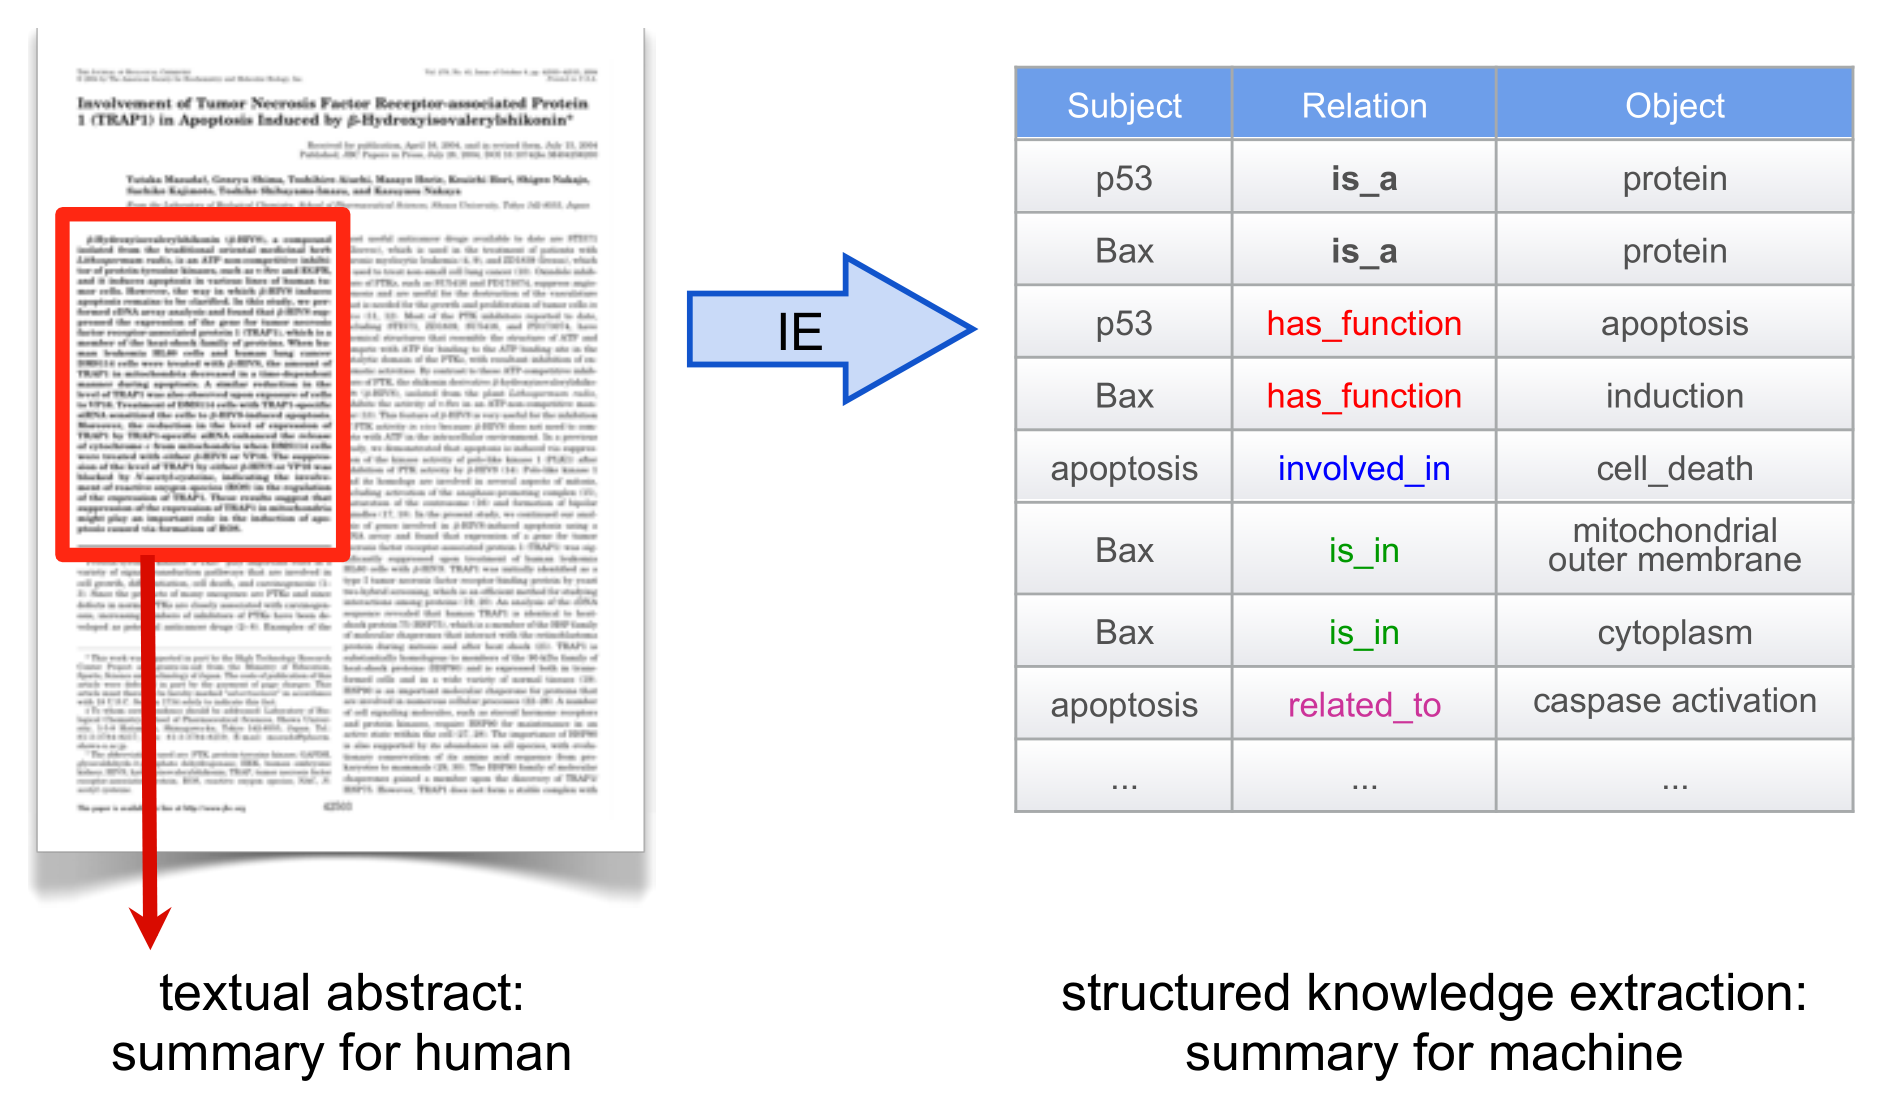

(Graphik von Luke Zettlemoyer)

## NLTK-Werkzeuge

Das NLTK enthält hierfür das Modul [`nltk.sem.relextract`](https://www.nltk.org/api/nltk.sem.relextract.html#module-nltk.sem.relextract). Allerdings muss man sagen, dass das Angebot sehr rudimentär ist. Das Modul enthält eine Funktion `extract_rels()`, die sich jedoch auf genau zwei (!) vorgegebene Corpora anwenden lässt (`ieee` und `conll2002`). Über den Parameter `pattern` lässt sich als regulärer Ausdruck angeben, welcher Wortform-String sich zwischen zwei NEs befinden darf.    

In [32]:
import re
nltk.download('ieer')

IN = re.compile(r'.*\bin\b(?!\b.+ing)')
for doc in nltk.corpus.ieer.parsed_docs('NYT_19980315'):
    for rel in nltk.sem.extract_rels('ORG', 'LOC', doc,
                                     corpus='ieer', pattern=IN):
        print(nltk.sem.rtuple(rel))

[ORG: 'WHYY'] 'in' [LOC: 'Philadelphia']
[ORG: 'McGlashan &AMP; Sarrail'] 'firm in' [LOC: 'San Mateo']
[ORG: 'Freedom Forum'] 'in' [LOC: 'Arlington']
[ORG: 'Brookings Institution'] ', the research group in' [LOC: 'Washington']
[ORG: 'Idealab'] ', a self-described business incubator based in' [LOC: 'Los Angeles']
[ORG: 'Open Text'] ', based in' [LOC: 'Waterloo']
[ORG: 'WGBH'] 'in' [LOC: 'Boston']
[ORG: 'Bastille Opera'] 'in' [LOC: 'Paris']
[ORG: 'Omnicom'] 'in' [LOC: 'New York']
[ORG: 'DDB Needham'] 'in' [LOC: 'New York']
[ORG: 'Kaplan Thaler Group'] 'in' [LOC: 'New York']
[ORG: 'BBDO South'] 'in' [LOC: 'Atlanta']
[ORG: 'Georgia-Pacific'] 'in' [LOC: 'Atlanta']


[nltk_data] Downloading package ieer to
[nltk_data]     /Users/dr.elsherif/nltk_data...
[nltk_data]   Package ieer is already up-to-date!


Immerhin gibt es noch zwei weitere Funktionen in `nltk.sem.relextract`, mit denen sich beliebige `Tree`-Objekte entsprechend weiterverarbeiten lassen. Hier ein kurzes Beispiel.

Zunächst identifizieren und klassifizieren wir NEs mit `nltk.chunk.ne_chunk()`, dem NLTK-eigenen NE-Chunker: 

In [33]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
ne_chunked_sentence = nltk.chunk.ne_chunk([[(word, pos) for word, pos, chunk, ne in sent]
                                           for sent in conll2003_ioball_testa][10])

print(ne_chunked_sentence)

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/dr.elsherif/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/dr.elsherif/nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  He/PRP
  was/VBD
  well/RB
  backed/VBN
  by/IN
  (GPE England/NNP)
  hopeful/JJ
  (PERSON Mark/NNP Butcher/NNP)
  who/WP
  made/VBD
  70/CD
  as/IN
  (PERSON Surrey/NNP)
  closed/VBD
  on/IN
  429/CD
  for/IN
  seven/CD
  ,/,
  a/DT
  lead/NN
  of/IN
  234/CD
  ./.)


Dann können wir mit den beiden Funktionen `nltk.sem.relextract.tree2semi_rel()` und `nltk.sem.relextract.semi_rel2reldict()` die NEs und die "Filler" zwischen den NEs bestimmen und leicht die Relationen extrahieren:

In [34]:
nltk.sem.relextract.semi_rel2reldict(
    nltk.sem.relextract.tree2semi_rel(ne_chunked_sentence))

[defaultdict(str,
             {'lcon': 'He/PRP was/VBD well/RB backed/VBN by/IN',
              'subjclass': 'GPE',
              'subjtext': 'England/NNP',
              'subjsym': 'england',
              'filler': 'hopeful/JJ',
              'untagged_filler': 'hopeful',
              'objclass': 'PERSON',
              'objtext': 'Mark/NNP Butcher/NNP',
              'objsym': 'mark_butcher',
              'rcon': 'who/WP made/VBD 70/CD as/IN'})]

Mit diesen Informationen können wir schließlich relativ einfach z.B. ORGANIZATION-LOCATION-Relationen aus `conll2003_ioball_testa` als eine Liste von Tripeln der Form `('Organization','Filler','Location')` extrahieren. 

In [35]:
tagged_sents = [[(word,pos) for word,pos,chunk,ne in sent] for sent in conll2003_ioball_testa]
#chunked_sents = [nltk.chunk.ne_chunk(sent) for sent in tagged_sents]
chunked_sents = list(nltk.chunk.ne_chunk_sents(tagged_sents))
relationsdict = [nltk.sem.relextract.semi_rel2reldict(nltk.sem.relextract.tree2semi_rel(sent)) for sent in chunked_sents]

[(dict['subjsym'],dict['untagged_filler'],dict['objsym']) 
 for dict in [dict for i in relationsdict for dict in i]
 if dict['subjclass'] == 'ORGANIZATION' and dict['objclass'] == 'GPE' 
    and re.match('[^,]* (on|in|at|near|from|to)$',dict['untagged_filler'])
]

[('uefa', 'came down heavily on', 'belgian'),
 ('security', 'and Cooperation in', 'europe'),
 ('security', 'and Cooperation in', 'europe'),
 ('interfax',
  'news agency reported on Tuesday the officials had departed for negotiations in',
  'germany'),
 ('security', 'and Cooperation in', 'europe'),
 ('republican', 'stadium in', 'chisinau'),
 ('un', 'official in', 'baghdad'),
 ('un', 'Interim Force in', 'lebanon'),
 ('kdp', 'headquarters in', 'saladdin'),
 ('nations', 'relief officials said on Saturday the fighting in', 'arbil')]

# Appendix

## Maximum Entropy Classifier

In [36]:
from nltk.classify import MaxentClassifier

ne_me_chunker = NamedEntityChunker(conll2003_pair_train,
                                   feature_detector=ne_features,
                                   classifier_builder=lambda train_feats:
                                       MaxentClassifier.train(train_feats, max_iter=10))

  ==> Training (10 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -2.19722        0.833
             2          -0.21484        0.869
             3          -0.18428        0.924
             4          -0.16599        0.936
             5          -0.15328        0.943
             6          -0.14339        0.949
             7          -0.13518        0.955
             8          -0.12813        0.960
             9          -0.12196        0.965
         Final          -0.11647        0.969


In [37]:
print("Tagger accuracy: ", ne_me_chunker.tagger.accuracy(conll2003_pair_testa))
print(ne_me_chunker.accuracy(conll2003_tree_testa))

Tagger accuracy:  0.9447840816167594
ChunkParse score:
    IOB Accuracy:  94.0%%
    Precision:     65.7%%
    Recall:        67.4%%
    F-Measure:     66.5%%


# Literaturangaben

Jurafsky, Daniel & James H. Martin. 2021. Speech and Language Processing. An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition. Draft of September 21, 2021. https://web.stanford.edu/jurafsky/slp3/ed3book.pdf.